In [5]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt

# Ruta a la carpeta principal
main_folder = 'proyecto final/chest_xray'

# Crear listas para almacenar rutas de imágenes y etiquetas
image_paths = []
labels = []

# Recorre las carpetas de entrenamiento (NORMAL y PNEUMONIA)
for label in ['NORMAL', 'PNEUMONIA']:
    folder_path = os.path.join(main_folder, 'train', label)
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        image_paths.append(img_path)
        labels.append(label)

# Crea un DataFrame para visualizar y analizar los datos
data = pd.DataFrame({'Image_Path': image_paths, 'Label': labels})

# Verifica las primeras filas del DataFrame
print(data.head())

                                          Image_Path   Label
0  proyecto final/chest_xray\train\NORMAL\IM-0115...  NORMAL
1  proyecto final/chest_xray\train\NORMAL\IM-0117...  NORMAL
2  proyecto final/chest_xray\train\NORMAL\IM-0119...  NORMAL
3  proyecto final/chest_xray\train\NORMAL\IM-0122...  NORMAL
4  proyecto final/chest_xray\train\NORMAL\IM-0125...  NORMAL


Label
PNEUMONIA    3875
NORMAL       1341
Name: count, dtype: int64


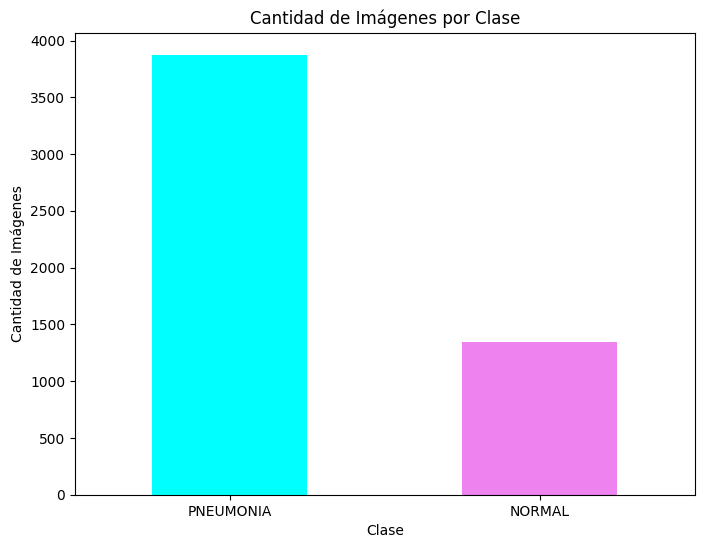

In [6]:
# Cantidad de imágenes por clase
class_counts = data['Label'].value_counts()
print(class_counts)
# Graficar la cantidad de imágenes por clase
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['cyan', 'violet'])
plt.title('Cantidad de Imágenes por Clase')
plt.xlabel('Clase')
plt.ylabel('Cantidad de Imágenes')
plt.xticks(rotation=0) 
plt.show()

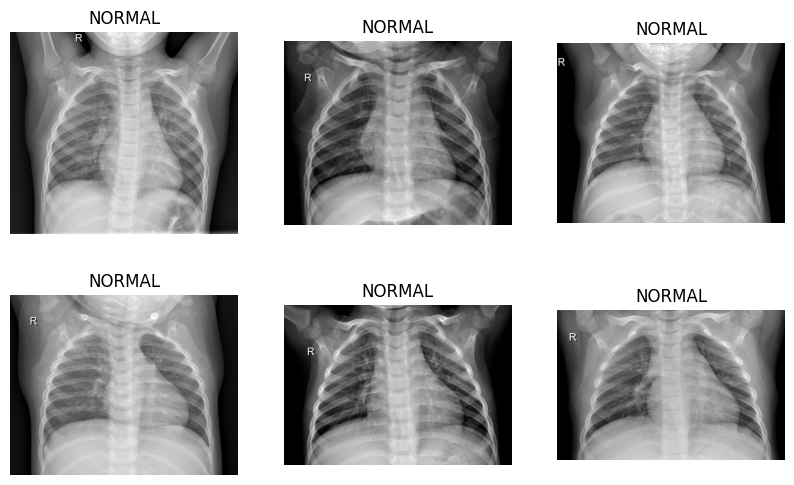

In [7]:
# Visualiza algunas imágenes de ejemplo
plt.figure(figsize=(10, 6))
for i in range(6):
    img = cv2.imread(data['Image_Path'][i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(data['Label'][i])
    plt.axis('off')
plt.show()

In [8]:
# Verifica si hay imágenes dañadas o no válidas
invalid_images = []
for index, row in data.iterrows():
    img_path = row['Image_Path']
    img = cv2.imread(img_path)
    if img is None:
        invalid_images.append(img_path)

# Elimina imágenes no válidas del DataFrame
data = data[~data['Image_Path'].isin(invalid_images)]

# Aplica técnicas de balanceo de clases si es necesario (submuestreo)
# Aquí se supone que 'data' contiene las imágenes válidas después de la limpieza
class_minority = data['Label'].value_counts().idxmin()
class_majority = data['Label'].value_counts().idxmax()
samples_to_remove = data['Label'].value_counts()[class_majority] - data['Label'].value_counts()[class_minority]
indices_to_remove = data[data['Label'] == class_majority].sample(samples_to_remove, random_state=42).index
data = data.drop(indices_to_remove)

# Verifica nuevamente la cantidad de imágenes por clase
class_counts_after_balance = data['Label'].value_counts()
print(class_counts_after_balance)

Label
NORMAL       1341
PNEUMONIA    1341
Name: count, dtype: int64


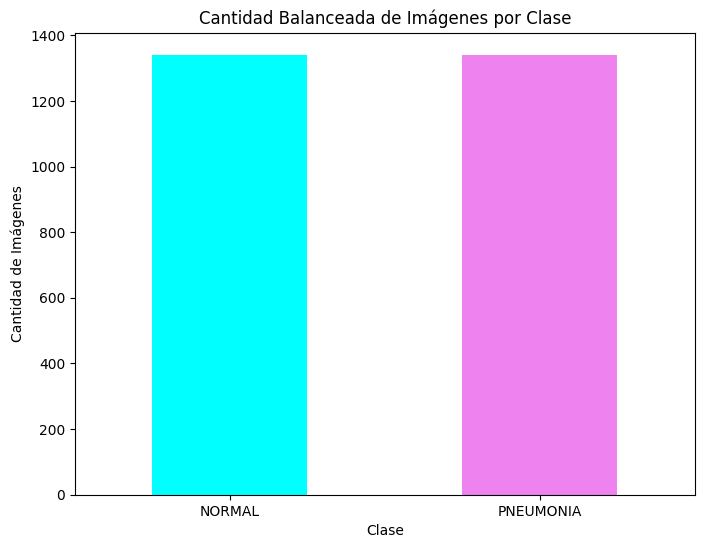

In [9]:
# Grafica nueva cantidad de imágenes por clase balanceada
plt.figure(figsize=(8, 6))
class_counts_after_balance.plot(kind='bar', color=['cyan', 'violet'])
plt.title('Cantidad Balanceada de Imágenes por Clase')
plt.xlabel('Clase')
plt.ylabel('Cantidad de Imágenes')
plt.xticks(rotation=0) 
plt.show()

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Ruta a la carpeta principal
main_folder = 'proyecto final/chest_xray'

# Carga y redimensiona las imágenes a un tamaño uniforme
def load_and_resize_image(image_path, target_size):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, target_size)
    return img_resized

# Tamaño de imagen deseado
target_size = (128, 128)

# Crea listas para almacenar imágenes y etiquetas
images = []
labels = []

# Recorre las carpetas de entrenamiento (NORMAL y PNEUMONIA)
for label in ['NORMAL', 'PNEUMONIA']:
    folder_path = os.path.join(main_folder, 'train', label)
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        img_resized = load_and_resize_image(img_path, target_size)
        images.append(img_resized)
        labels.append(label)

# Normaliza los valores de píxeles para que estén en el rango [0, 1]
images = np.array(images) / 255.0

# Codifica las etiquetas a valores numéricos
label_mapping = {'NORMAL': 0, 'PNEUMONIA': 1}
labels_encoded = [label_mapping[label] for label in labels]
labels_encoded = np.array(labels_encoded)

# Divide los conjuntos de datos en train, test y val
X_train, X_temp, y_train, y_temp = train_test_split(images, labels_encoded, test_size=0.2, stratify=labels_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Convierte las etiquetas a formato one-hot
y_train_onehot = to_categorical(y_train)
y_val_onehot = to_categorical(y_val)
y_test_onehot = to_categorical(y_test)

print("Forma de los conjuntos de datos:")
print("X_train:", X_train.shape)
print("y_train:", y_train_onehot.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val_onehot.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test_onehot.shape)

Forma de los conjuntos de datos:
X_train: (4172, 128, 128, 3)
y_train: (4172, 2)
X_val: (522, 128, 128, 3)
y_val: (522, 2)
X_test: (522, 128, 128, 3)
y_test: (522, 2)


In [11]:
#CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Crear el modelo CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Capa de dropout para reducir el overfitting
    Dense(2, activation='softmax')  # 2 clases: NORMAL y PNEUMONIA
])

In [12]:
# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train_onehot, 
                    validation_data=(X_val, y_val_onehot), 
                    epochs=10, batch_size=32)

Epoch 1/10
131/131 [==============================] - 33s 246ms/step - loss: 0.3735 - accuracy: 0.8437 - val_loss: 0.1271 - val_accuracy: 0.9655
Epoch 2/10
131/131 [==============================] - 32s 247ms/step - loss: 0.1697 - accuracy: 0.9396 - val_loss: 0.1025 - val_accuracy: 0.9655
Epoch 3/10
131/131 [==============================] - 33s 252ms/step - loss: 0.1130 - accuracy: 0.9609 - val_loss: 0.0770 - val_accuracy: 0.9713
Epoch 4/10
131/131 [==============================] - 31s 239ms/step - loss: 0.1233 - accuracy: 0.9585 - val_loss: 0.0837 - val_accuracy: 0.9674
Epoch 5/10
131/131 [==============================] - 31s 239ms/step - loss: 0.0927 - accuracy: 0.9698 - val_loss: 0.0684 - val_accuracy: 0.9751
Epoch 6/10
131/131 [==============================] - 32s 245ms/step - loss: 0.0827 - accuracy: 0.9724 - val_loss: 0.0731 - val_accuracy: 0.9732
Epoch 7/10
131/131 [==============================] - 31s 234ms/step - loss: 0.0806 - accuracy: 0.9729 - val_loss: 0.0707 - val_ac

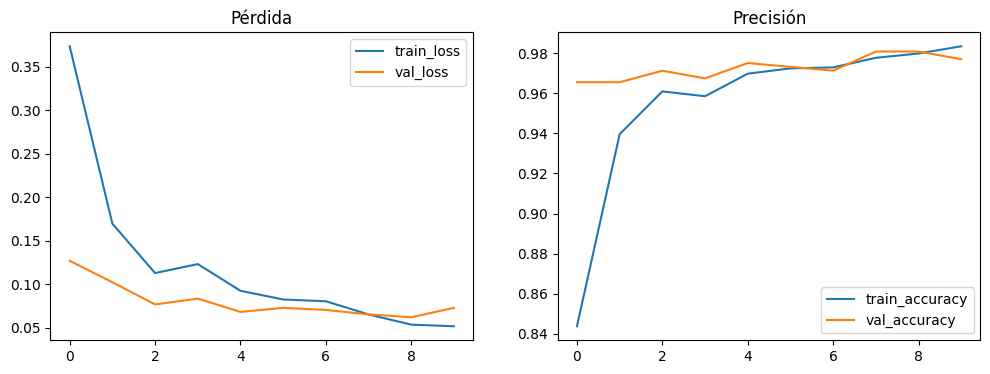

In [13]:
# Generar gráficas de pérdida y precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Pérdida')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Precisión')
plt.show()

In [14]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot)
print(f"Pérdida en el conjunto de prueba: {test_loss}")
print(f"Precisión en el conjunto de prueba: {test_accuracy}")

17/17 [==============================] - 1s 48ms/step - loss: 0.0629 - accuracy: 0.9732
Pérdida en el conjunto de prueba: 0.06291112303733826
Precisión en el conjunto de prueba: 0.9731800556182861


In [15]:
# Generar métricas de rendimiento
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

print("Matriz de confusión:")
print(confusion_matrix(y_true, y_pred_classes))

print("Reporte de clasificación:")
print(classification_report(y_true, y_pred_classes, target_names=label_mapping.keys()))

17/17 [==============================] - 1s 47ms/step
Matriz de confusión:
[[126   8]
 [  6 382]]
Reporte de clasificación:
              precision    recall  f1-score   support

      NORMAL       0.95      0.94      0.95       134
   PNEUMONIA       0.98      0.98      0.98       388

    accuracy                           0.97       522
   macro avg       0.97      0.96      0.96       522
weighted avg       0.97      0.97      0.97       522



In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calcular métricas de rendimiento
precision = precision_score(y_true, y_pred_classes)
recall = recall_score(y_true, y_pred_classes)
f1 = f1_score(y_true, y_pred_classes)

print(f"Precisión en el conjunto de prueba: {precision}")
print(f"Exhaustividad (Recall) en el conjunto de prueba: {recall}")
print(f"Puntuación F1 en el conjunto de prueba: {f1}")

Precisión en el conjunto de prueba: 0.9794871794871794
Exhaustividad (Recall) en el conjunto de prueba: 0.9845360824742269
Puntuación F1 en el conjunto de prueba: 0.9820051413881747


In [17]:
from sklearn.metrics import confusion_matrix

# Generar matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Imprimir la matriz de confusión
print("Matriz de Confusión:")
print(conf_matrix)


Matriz de Confusión:
[[126   8]
 [  6 382]]


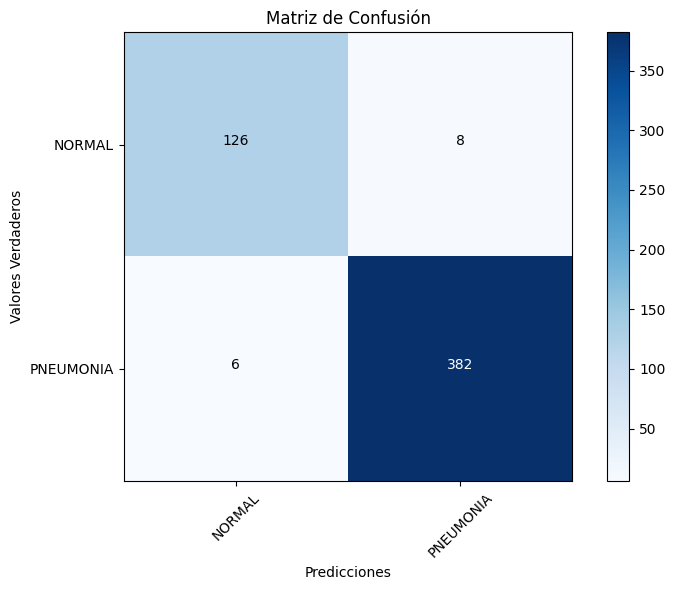

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generar matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Definir etiquetas de clases
class_labels = label_mapping.keys()

# Crear una figura de Matplotlib
plt.figure(figsize=(8, 6))

# Crear el gráfico de barras
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.colorbar()

# Etiquetas en los ejes
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Anotar los valores en las celdas
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

# Etiquetas de los ejes
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


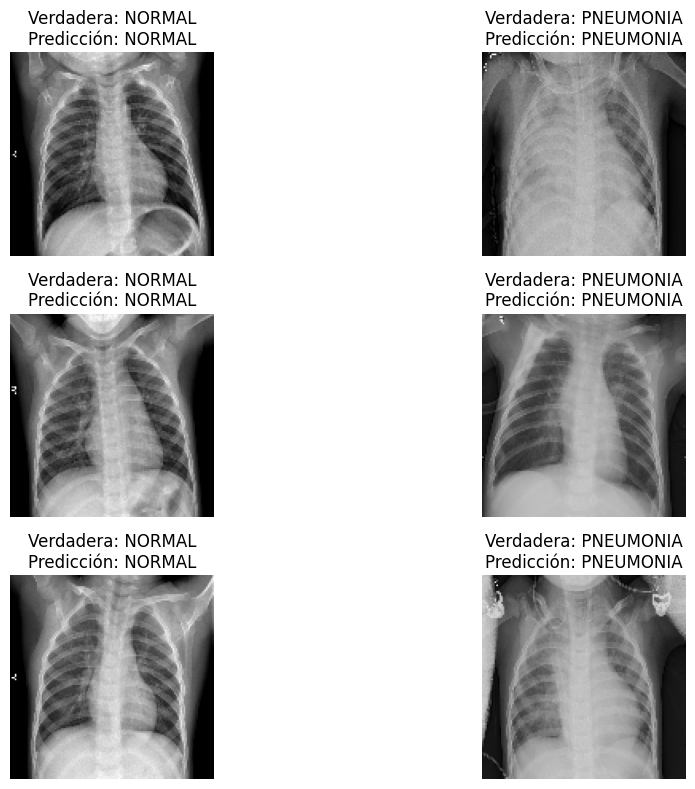

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Función para mostrar imágenes con etiquetas verdaderas y predecidas
def visualize_predictions(images, true_labels, predicted_labels, label_mapping):
    plt.figure(figsize=(12, 8))
    num_images = len(images)
    
    for i in range(num_images):
        plt.subplot(num_images//2, 2, i+1)
        plt.imshow(images[i])
        true_label = label_mapping[true_labels[i]]
        predicted_label = label_mapping[predicted_labels[i]]
        title = f'Verdadera: {true_label}\nPredicción: {predicted_label}'
        plt.title(title)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Obtener índices aleatorios para mostrar algunas imágenes
num_images_to_show = 6
random_indices = np.random.choice(len(X_test), num_images_to_show, replace=False)

# Obtener imágenes y etiquetas correspondientes a los índices seleccionados
images_to_show = X_test[random_indices]
true_labels_to_show = y_true[random_indices]
predicted_labels_to_show = y_pred_classes[random_indices]

# Mapeo de etiquetas numéricas a etiquetas de texto
label_mapping = {0: 'NORMAL', 1: 'PNEUMONIA'}

# Mostrar imágenes con etiquetas verdaderas y predecidas
visualize_predictions(images_to_show, true_labels_to_show, predicted_labels_to_show, label_mapping)

In [34]:
import gradio as gr

# Define la función de predicción
def pneumoniaPrediction(img):
    try:
        img = np.array(img)  # Convierte la imagen a un arreglo NumPy
        img_copy = img.copy()  # Realiza una copia de la imagen para evitar problemas de referencia
        img_copy = cv2.resize(img_copy, (128, 128))  # Redimensiona la copia de la imagen a (128, 128)
        img_copy = img_copy / 255.0  # Normaliza los valores de píxeles
        img_copy = img_copy.reshape(-1, 128, 128, 3)  # Asegura que tenga la misma forma que la entrada del modelo
        prediction_prob = model.predict(img_copy)[0][0]  # Obtiene la probabilidad de predicción

        if prediction_prob < 0.5:
            imgClass = "Neumonía"
        else:
            imgClass = "Normal"

        return imgClass
    except Exception as e:
        return f"Error: {str(e)}"

In [35]:
# Agregar una nueva entrada para cargar imágenes de prueba
test_image = gr.inputs.Image(shape=(128, 128))  # Asegura que la forma coincida con (128, 128)

C:\Users\Rockstars\AppData\Local\Temp\ipykernel_8032\1343180700.py:2: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  test_image = gr.inputs.Image(shape=(128, 128))  # Asegura que la forma coincida con (128, 128)
C:\Users\Rockstars\AppData\Local\Temp\ipykernel_8032\1343180700.py:2: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  test_image = gr.inputs.Image(shape=(128, 128))  # Asegura que la forma coincida con (128, 128)


In [36]:
# Define la interfaz de Gradio con la nueva entrada
iface = gr.Interface(
    fn=pneumoniaPrediction,
    inputs=[test_image],  # Agregar la nueva entrada de imagen de prueba
    outputs="text",  # Usa "text" para la salida de texto
    title="Detección de neumonía con imágenes de RX",
    description="Cargue una imagen de radiografía de tórax para predecir si muestra neumonía o no.",
    live=True,
)
# Lanza la interfaz
iface.launch()

Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 24ms/step


c:\Users\Rockstars\Desktop\proyecto final\chest_xray\venv\Lib\site-packages\gradio\components\button.py:89: UserWarning: Using the update method is deprecated. Simply return a new object instead, e.g. `return gr.Button(...)` instead of `return gr.Button.update(...)`.
  warnings.warn(


1/1 [==============================] - 0s 26ms/step


c:\Users\Rockstars\Desktop\proyecto final\chest_xray\venv\Lib\site-packages\gradio\components\button.py:89: UserWarning: Using the update method is deprecated. Simply return a new object instead, e.g. `return gr.Button(...)` instead of `return gr.Button.update(...)`.
  warnings.warn(


1/1 [==============================] - 0s 29ms/step


c:\Users\Rockstars\Desktop\proyecto final\chest_xray\venv\Lib\site-packages\gradio\components\button.py:89: UserWarning: Using the update method is deprecated. Simply return a new object instead, e.g. `return gr.Button(...)` instead of `return gr.Button.update(...)`.
  warnings.warn(


1/1 [==============================] - 0s 23ms/step


c:\Users\Rockstars\Desktop\proyecto final\chest_xray\venv\Lib\site-packages\gradio\components\button.py:89: UserWarning: Using the update method is deprecated. Simply return a new object instead, e.g. `return gr.Button(...)` instead of `return gr.Button.update(...)`.
  warnings.warn(


1/1 [==============================] - 0s 26ms/step


c:\Users\Rockstars\Desktop\proyecto final\chest_xray\venv\Lib\site-packages\gradio\components\button.py:89: UserWarning: Using the update method is deprecated. Simply return a new object instead, e.g. `return gr.Button(...)` instead of `return gr.Button.update(...)`.
  warnings.warn(


1/1 [==============================] - 0s 26ms/step


c:\Users\Rockstars\Desktop\proyecto final\chest_xray\venv\Lib\site-packages\gradio\components\button.py:89: UserWarning: Using the update method is deprecated. Simply return a new object instead, e.g. `return gr.Button(...)` instead of `return gr.Button.update(...)`.
  warnings.warn(


1/1 [==============================] - 0s 31ms/step


c:\Users\Rockstars\Desktop\proyecto final\chest_xray\venv\Lib\site-packages\gradio\components\button.py:89: UserWarning: Using the update method is deprecated. Simply return a new object instead, e.g. `return gr.Button(...)` instead of `return gr.Button.update(...)`.
  warnings.warn(


1/1 [==============================] - 0s 28ms/step


c:\Users\Rockstars\Desktop\proyecto final\chest_xray\venv\Lib\site-packages\gradio\components\button.py:89: UserWarning: Using the update method is deprecated. Simply return a new object instead, e.g. `return gr.Button(...)` instead of `return gr.Button.update(...)`.
  warnings.warn(


1/1 [==============================] - 0s 39ms/step


c:\Users\Rockstars\Desktop\proyecto final\chest_xray\venv\Lib\site-packages\gradio\components\button.py:89: UserWarning: Using the update method is deprecated. Simply return a new object instead, e.g. `return gr.Button(...)` instead of `return gr.Button.update(...)`.
  warnings.warn(


1/1 [==============================] - 0s 28ms/step


c:\Users\Rockstars\Desktop\proyecto final\chest_xray\venv\Lib\site-packages\gradio\components\button.py:89: UserWarning: Using the update method is deprecated. Simply return a new object instead, e.g. `return gr.Button(...)` instead of `return gr.Button.update(...)`.
  warnings.warn(


1/1 [==============================] - 0s 29ms/step


c:\Users\Rockstars\Desktop\proyecto final\chest_xray\venv\Lib\site-packages\gradio\components\button.py:89: UserWarning: Using the update method is deprecated. Simply return a new object instead, e.g. `return gr.Button(...)` instead of `return gr.Button.update(...)`.
  warnings.warn(


1/1 [==============================] - 0s 26ms/step


c:\Users\Rockstars\Desktop\proyecto final\chest_xray\venv\Lib\site-packages\gradio\components\button.py:89: UserWarning: Using the update method is deprecated. Simply return a new object instead, e.g. `return gr.Button(...)` instead of `return gr.Button.update(...)`.
  warnings.warn(


1/1 [==============================] - 0s 29ms/step
